---

Lambda School Data Science

*Unit 4, Sprint 1, Module 3*

---

# Document Classification (Prepare)

Today's guided module project will be different. You already know how to do classification. You already know how to extract features from documents. So? That means you're ready to combine and practice those skills in a kaggle competition. We we will open with a five minute sprint explaining the competition, and then give you 25 minutes to work. After those twenty five minutes are up, I will give a 5-minute demo on a NLP technique that will help you with document classification (*and **maybe** the competition*).

Today's all about having fun and practicing your skills. The competition will begin

## Learning Objectives
* <a href="#p1">Part 1</a>: Text Feature Extraction & Classification Pipelines
* <a href="#p2">Part 2</a>: Latent Semantic Indexing
* <a href="#p3">Part 3</a>: Word Embeddings with Spacy

# Text Feature Extraction & Classification Pipelines (Learn)
<a id="p1"></a>

## Overview

Sklearn pipelines allow you to stitch together multiple components of a machine learning process. The idea is that you can pass you raw data and get predictions out of the pipeline. This ability to pass raw input and receive a prediction from a singular class makes pipelines well suited for production, because you can pickle a a pipeline without worry about other data preprocessing steps.

*Note:* Each time we call the pipeline during grid search, each component is fit again. The vectorizer (tf-idf) is transforming our entire vocabulary during each cross-validation fold. That transformation adds significant run time to our grid search. There *might* be interactions between the vectorizer and our classifier, so we estimate their performance together in the code below. However, if your goal is to reduce run time. Train your vectorizer separately (ie out of the grid-searched pipeline).

In [1]:
# Import Statements
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# Dataset categories (limit to 3 categories vs. 20 to reduce runtime)
categories = ['sci.electronics',
              'rec.sport.baseball',
              'rec.sport.hockey']

# Load training data
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

# Load testing data
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

print(f'Training Samples: {len(newsgroups_train.data)}')
print(f'Testing Samples: {len(newsgroups_test.data)}')

Training Samples: 1788
Testing Samples: 1189


In [3]:
type(newsgroups_train)

sklearn.utils._bunch.Bunch

In [4]:
dir(newsgroups_train)

['DESCR', 'data', 'filenames', 'target', 'target_names']

In [5]:
newsgroups_train.data[0]

"\nOh yeah, how come Dino could never take the Caps out of the Patrick\nDivision?  He choked up 3 games to 1 last year and got swept away in\nthe second round two years ago.  He rarely, if ever, makes it out of the\ndivision.\n\n\nSo are the Islanders, but they can still pull it out.  Vancouver has Winnipeg's\n number, so it really doesn't matter.\n\n\n\n Kings always seem to go at least 6 or 7, they never play a four or five\ngame serious.  There's a difference between battling it out and pulling it\nout, as I take Calgary to pull it out in 7."

In [6]:
newsgroups_train.target

array([1, 0, 2, ..., 1, 1, 2])

In [7]:
newsgroups_train.target_names

['rec.sport.baseball', 'rec.sport.hockey', 'sci.electronics']

### Explore the Data

Building and training a model is only one part of the workflow. Understanding the basic characteristics of your data beforehand will enable you to build a better model. This could mean obtaining higher accuracy, requiring less data for training, or potentially fewer computation resources.

Here we have a few helper functions that will let us explore the dataset.

In [8]:
def get_num_words_per_sample(sample_texts):
    """Gets the median number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s.split()) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()


def plot_frequency_distribution_of_ngrams(sample_texts,
                                          num_ngrams=50,
                                          **kwargs):
    """Plots the frequency distribution of n-grams.

    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    """
    # Instantiate the vectorizer
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names_out())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    plt.figure(figsize=(18,6))
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of n-grams')
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()

In [9]:
median_words_per_sample = get_num_words_per_sample(newsgroups_train.data)
print(f'Median words per sample: {median_words_per_sample}')

Median words per sample: 75.0


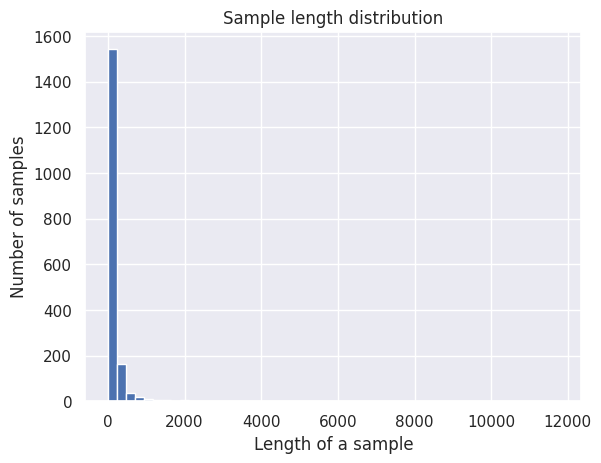

In [10]:
plot_sample_length_distribution(newsgroups_train.data)

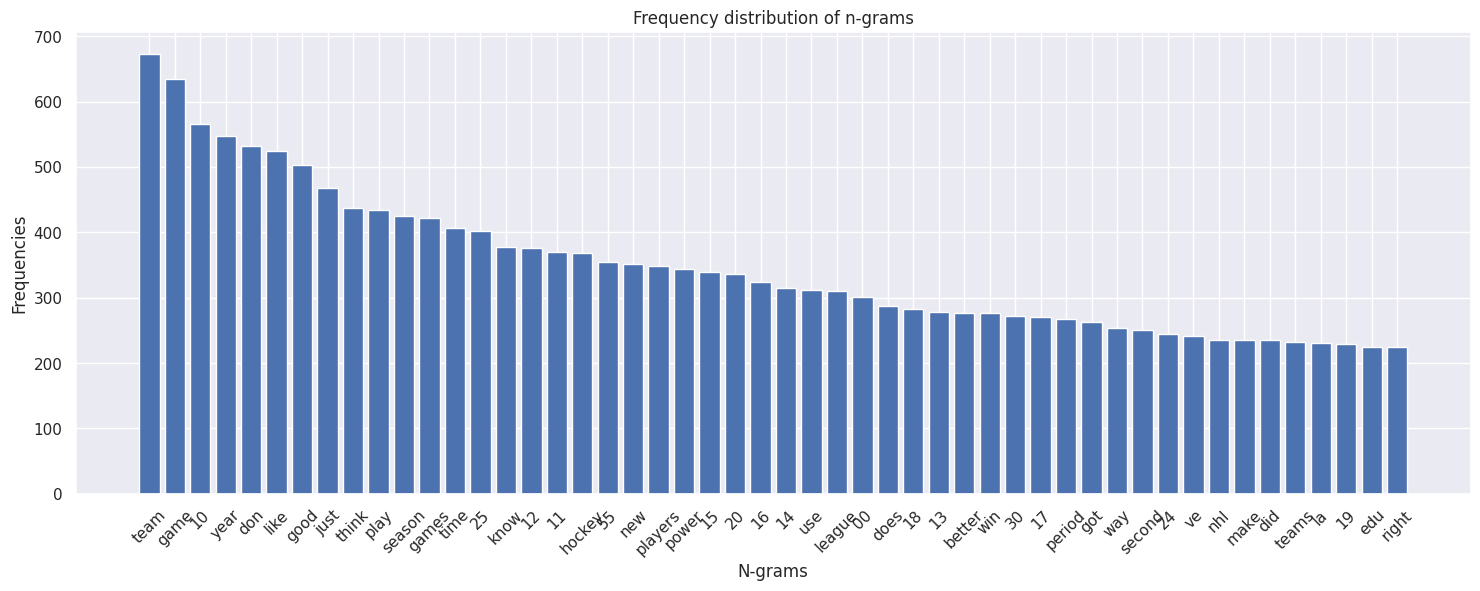

In [11]:
# Create args required for vectorizing
kwargs = {
  'ngram_range': (1, 2),
  'stop_words': 'english',
  'max_df': 0.25,
}

plot_frequency_distribution_of_ngrams(newsgroups_train.data,
                                      num_ngrams=50,
                                      **kwargs)

### Choose a Modeling Approach

Reference: https://developers.google.com/machine-learning/guides/text-classification/step-2-5

At this point, we have assembled our dataset and gained insights into the key characteristics of our data. Next, based on the metrics we gathered we should think about which classification model we should use. This means asking questions such as:

- “How do we present the text data to an algorithm that expects numeric input?” (Data preprocessing and vectorization)
- “What type of model should we use?”
- “What configuration parameters should we use for our model?”, etc.

In the reference guide above, Google attempts to significantly simplify the process of selecting a text classification model. For a given dataset, our goal is to find the algorithm that achieves close to maximum accuracy while minimizing computation time required for training. We ran a large number (~450K) of experiments across problems of different types (especially sentiment analysis and topic classification problems), using 12 datasets, alternating for each dataset between different data preprocessing techniques and different model architectures. This helped us identify dataset parameters that influence optimal choices.

The model selection algorithm and flowchart below are a summary of our experimentation.

In [12]:
sw_ratio = len(newsgroups_train.data) / median_words_per_sample
print(f'Number of Samples / Median Words per Sample ratio: {int(sw_ratio)}')

Number of Samples / Median Words per Sample ratio: 23


![](https://developers.google.com/machine-learning/guides/text-classification/images/TextClassificationFlowchart.png)

## Build a Baseline TF-IDF Model with Support Vector Machine (or Logistic Regression)

In [13]:
import re

def my_tokenizer(text):
    clean_text = re.sub('[^a-zA-Z ]', '', text)
    tokens = [token.lower() for token in clean_text.split() if len(token) > 2]

    return tokens

In [14]:
from sklearn.svm import LinearSVC

# Create Pipeline Components
vect = TfidfVectorizer(stop_words='english',
                       tokenizer=my_tokenizer)
svm = LinearSVC()

In [15]:
import pandas as pd

# Get sparse dtm
dtm = vect.fit_transform(newsgroups_train.data)

# Convert to dataframe
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names_out())
print(dtm.shape)
dtm.head()

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(1788, 29048)


,aaa,aaaand,aaahh,aaamajors,aaaoffice,aaaunless,aac,aadams,aagrendalcorpsuncomto,aalternate,...,zoo,zoomed,ztimer,zubov,zubovand,zupancic,zupcic,zurich,zzzzzz,zzzzzzt
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.138969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
### BEGIN SOLUTION

# Define the Pipeline
pipe = Pipeline([
    ('vect', vect),
    ('clf', svm)
])

### END SOLUTION

In [17]:
parameters = {
    'vect__ngram_range': ((1,1), (1,2)),    # Consider unigrams or unigrams/bigrams
    'vect__max_df': (0.25, 0.5),            # Removes common words
    'vect__min_df': (2, 3, 5),              # Removes rare words
    'clf__C': (0.1, 0.5, 1)                 # Strength of regularization penalty (higher -> more)
}

# Map y from integer label to category
y_train = [newsgroups_train.target_names[label] for label in newsgroups_train.target]
y_test = [newsgroups_test.target_names[label] for label in newsgroups_test.target]

# Run grid search
grid_search = GridSearchCV(pipe, parameters, cv=5, n_jobs=4, verbose=1)
grid_search.fit(newsgroups_train.data, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(stop_words='english',
                                                        tokenizer=<function my_tokenizer at 0x79ba4f474220>)),
                                       ('clf', LinearSVC())]),
             n_jobs=4,
             param_grid={'clf__C': (0.1, 0.5, 1), 'vect__max_df': (0.25, 0.5),
                         'vect__min_df': (2, 3, 5),
                         'vect__ngram_range': ((1, 1), (1, 2))},
             verbose=1)

In [18]:
grid_search.best_score_

np.float64(0.8926278891444847)

In [19]:
grid_search.best_params_

{'clf__C': 0.5,
 'vect__max_df': 0.25,
 'vect__min_df': 3,
 'vect__ngram_range': (1, 2)}

In [20]:
from sklearn.metrics import accuracy_score

# Evaluate on test data
y_test_pred = grid_search.predict(newsgroups_test.data)
accuracy_score(y_test, y_test_pred)

0.8814129520605551

In [21]:
from sklearn.metrics import classification_report

# Print the classification report
print(classification_report(y_test, y_test_pred))

                    precision    recall  f1-score   support

rec.sport.baseball       0.83      0.87      0.85       397
  rec.sport.hockey       0.90      0.86      0.88       399
   sci.electronics       0.91      0.91      0.91       393

          accuracy                           0.88      1189
         macro avg       0.88      0.88      0.88      1189
      weighted avg       0.88      0.88      0.88      1189



## Bonus Section: Explainability

In [22]:
!pip install eli5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.4/108.4 kB 5.5 MB/s eta 0:00:00


In [23]:
### BEGIN SOLUTION

# Extract the vectorizer and model from grid_search pipeline
best_model = grid_search.best_estimator_
vect = best_model.named_steps['vect']
clf = best_model.named_steps['clf']

### END SOLUTION

In [24]:
import eli5

eli5.show_weights(clf, vec=vect, top=20)

## Follow Along

What you should be doing now:
1. Go to the Kaggle competition notebook.
3. Train a model & try:
    - Creating a Text Extraction & Classification Pipeline
    - Tune the pipeline with a `GridSearchCV` or `RandomizedSearchCV`
4. Make a submission to Kaggle

## Latent Semantic Indexing (Learn)
<a id="p2"></a>

## Overview

Below is an excellent visual representation of *Latent Semantic Indexing*, also known as LSI, and as *Latent Semantic Analyis*, or LSA.<br>
Latent Semantic Indexing is a technique for Topic  Modeling, i.e. grouping a corpus of documents into similar clusters that can then be examined for topics. In the graphic below read "context" as "topics"<br>

Grouping documents into clusters with different topics is also a form of dimensionality reduction, because the document can be represented by a vector of topics instead of a vector of tokens. <br>

If your document-term matrix has $m$ documents and $n$ terms, <br>and the number of topics you want to find is $k$, then:
- The Term-Document Matrix is $n\times m$ (the transpose of the Document-Term Matrix)
- The Word Assignment to Topics Matrix is $n \times k$
- The Topic Importance Matrix is $k \times k$
- The Topic Distribution Across Documents Matrix is $k \times m$

![](https://media.geeksforgeeks.org/wp-content/uploads/20210406165951/Screenshot20210406165933.png)<br>
Image Credit: [Geeks for Geeks](https://media.geeksforgeeks.org/)

The image above shows a decomposition of the term-document matrix into a product of three matrices.<br>

- word = term (token or lemma)
- context means "topic" or document grouping

In the term-document matrix, the columns are vector representations of documents

In the words-context matrix, the columns represent relative weighting of words for each topic

In the context-document matrix, the columns represent relative weighting of topics for each document

**Take Aways:** LSA has two main benefits

1. Dimensionality Reduction (because you can choose the number of topics $k \ll n$)
2. Topic Modeling is a form of feature engineering, because it identifies latent (hidden) topics that are present in our doc-term matrix. <br>
This is something that counting vectorizers can't do (i.e. `CountVectorizer`, `TfidfVectorizer`)

In [25]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer

# Instantiate Singluar Value Decompsition class
svd = TruncatedSVD(n_components=2,
                   algorithm='randomized',
                   n_iter=10)

data = ['pizza', 'pizza hamburger cookie', 'hamburger',
        'ramen', 'sushi', 'ramen sushi']

vec = CountVectorizer()
dtm = vec.fit_transform(data)
dtm

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 9 stored elements and shape (6, 5)>

In [26]:
# Reduce dimensionality of dtm with SVD
X_reduced = svd.fit_transform(dtm)
X_reduced.round(2)

array([[ 0.63,  0.  ],
       [ 1.72,  0.  ],
       [ 0.63, -0.  ],
       [-0.  ,  0.71],
       [-0.  ,  0.71],
       [-0.  ,  1.41]])

In [27]:
# View as dataframe
dtm_reduced = pd.DataFrame(X_reduced.round(2), columns=['topic_1', 'topic_2'])
dtm_reduced.index = data
dtm_reduced

,topic_1,topic_2
pizza,0.63,0.00
pizza hamburger cookie,1.72,0.00
hamburger,0.63,-0.00
ramen,-0.00,0.71
sushi,-0.00,0.71
ramen sushi,-0.00,1.41


In [28]:
### BEGIN SOLUTION

# Define a text classification pipeline with LSI

vect = TfidfVectorizer(stop_words='english',
                       ngram_range=(1,2),
                       min_df=3,
                       max_df=0.25)

svd = TruncatedSVD(n_components=10,
                   algorithm='randomized',
                   n_iter=10)

svm = LinearSVC(C=0.5, penalty='l2')

pipe = Pipeline([
    ('vect', vect),
    ('svd', svd),
    ('clf', svm)
])
pipe

### END SOLUTION

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.25, min_df=3, ngram_range=(1, 2),
                                 stop_words='english')),
                ('svd', TruncatedSVD(n_components=10, n_iter=10)),
                ('clf', LinearSVC(C=0.5))])

In [29]:
# Run a grid search
parameters = {
    'svd__n_components': (100, 500, 1000),
}

grid_search = GridSearchCV(pipe, parameters, cv=5, n_jobs=4, verbose=1)
grid_search.fit(newsgroups_train.data, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(max_df=0.25, min_df=3,
                                                        ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('svd',
                                        TruncatedSVD(n_components=10,
                                                     n_iter=10)),
                                       ('clf', LinearSVC(C=0.5))]),
             n_jobs=4, param_grid={'svd__n_components': (100, 500, 1000)},
             verbose=1)

In [30]:
grid_search.best_score_

np.float64(0.9127677886797179)

In [31]:
grid_search.best_params_

{'svd__n_components': 500}

In [32]:
# Evaluate on test data
y_test_pred = grid_search.predict(newsgroups_test.data)
accuracy_score(y_test, y_test_pred)

0.9074852817493693

In [33]:
# Print the classification report
print(classification_report(y_test, y_test_pred))

                    precision    recall  f1-score   support

rec.sport.baseball       0.86      0.90      0.88       397
  rec.sport.hockey       0.93      0.89      0.91       399
   sci.electronics       0.94      0.93      0.94       393

          accuracy                           0.91      1189
         macro avg       0.91      0.91      0.91      1189
      weighted avg       0.91      0.91      0.91      1189



## Follow Along

What you should be doing now:
1. Go to the Kaggle competition notebook.
3. Train a model & try:
    - Creating a Text Extraction & Classification Pipeline
    - Tune the pipeline with a `GridSearchCV` or `RandomizedSearchCV`
    - -> Add Latent Semantic Indexing (lsi) into your pipeline.
4. Make a submission to Kaggle


## Challenge

Continue to apply Latent Semantic Indexing (LSI) to various datasets.

# Word Embeddings with Spacy (Learn)
<a id="p3"></a>

# Overview

In [34]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 26.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Restart runtime!

In [1]:
import spacy

# load in pre-trained glove model
nlp = spacy.load("en_core_web_md", disable=['parser', 'tagger'])

In [2]:
from sklearn.datasets import fetch_20newsgroups

# Dataset categories (limit to 3 categories vs. 20 to reduce runtime)
categories = ['sci.electronics',
              'rec.sport.baseball',
              'rec.sport.hockey']

# Load training data
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

# Load testing data
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

print(f'Training Samples: {len(newsgroups_train.data)}')
print(f'Testing Samples: {len(newsgroups_test.data)}')

Training Samples: 1788
Testing Samples: 1189


In [3]:
# Map y from integer label to category
y_train = [newsgroups_train.target_names[label] for label in newsgroups_train.target]
y_test = [newsgroups_test.target_names[label] for label in newsgroups_test.target]

In [4]:
doc = nlp("Natural lanugage processing is awesome!")
doc.vector

/usr/local/lib/python3.12/dist-packages/spacy/pipeline/lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


array([-6.41196668e-01, -3.13466676e-02, -2.96331570e-02, -1.02243334e-01,
       -8.03953335e-02,  2.96780676e-01,  1.46131679e-01, -1.84012651e-01,
        3.06401644e-02,  9.76783276e-01, -7.10414946e-02,  3.11840549e-02,
        1.38574675e-01,  2.30854154e-01, -2.75268313e-02, -6.18045032e-02,
        8.40278342e-02,  8.04515064e-01,  1.61893312e-02,  1.30953444e-02,
       -2.70529930e-02, -1.77815016e-02, -1.86736714e-02, -1.88851669e-01,
       -1.05348319e-01, -3.96378376e-02,  1.18458152e-01, -1.97777674e-01,
       -8.60658288e-02, -3.44682664e-01,  8.92500300e-03, -1.56467170e-01,
        1.55449986e-01, -1.78688660e-01, -1.65814996e-01, -3.75245027e-02,
        3.04166484e-03, -1.34233630e-03, -4.47548293e-02, -2.69506648e-02,
        1.27250001e-01, -2.63643354e-01, -4.13718596e-02,  1.81060359e-01,
        8.94933343e-02,  2.12182507e-01, -6.40136674e-02, -1.51023328e-01,
       -1.09599829e-01,  1.89021658e-02,  1.92746613e-02,  3.60345021e-02,
        2.01104507e-01,  

In [5]:
### BEGIN SOLUTION

# Define a function to return average word vector for a given document
def get_avg_word_vectors(docs):
    return [nlp(doc).vector for doc in docs]

### END SOLUTION

In [6]:
X = get_avg_word_vectors(newsgroups_train.data)
len(X) == len(newsgroups_train.data)

True

In [7]:
from sklearn.svm import LinearSVC

svm = LinearSVC(C=0.5, penalty='l2')
svm.fit(X, y_train)

LinearSVC(C=0.5)

In [8]:
X_test = get_avg_word_vectors(newsgroups_test.data)
len(X_test) == len(newsgroups_test.data)

/usr/local/lib/python3.12/dist-packages/spacy/pipeline/lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


True

In [9]:
from sklearn.metrics import accuracy_score

y_test_pred = svm.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.8216989066442388

In [10]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred))

                    precision    recall  f1-score   support

rec.sport.baseball       0.75      0.78      0.77       397
  rec.sport.hockey       0.81      0.76      0.78       399
   sci.electronics       0.91      0.92      0.92       393

          accuracy                           0.82      1189
         macro avg       0.82      0.82      0.82      1189
      weighted avg       0.82      0.82      0.82      1189



## Follow Along

## Challenge

What you should be doing now:
1. Go to the Kaggle competition notebook.
3. Train a model & try:
    - Creating a Text Extraction & Classification Pipeline
    - Tune the pipeline with a `GridSearchCV` or `RandomizedSearchCV`
    - Add some Latent Semantic Indexing (lsi) into your pipeline.
    - -> To extract word embeddings with Spacy and use those embeddings as your features for a classification model.
4. Make a submission to Kaggle

# Review

To review this module:
* Continue working on the Kaggle competition
* Find another text classification task to work on